In [5]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import pandas as pd
from scipy.optimize import fsolve
from scipy.integrate import quad
from scipy.stats import gaussian_kde
from scipy.optimize import root_scalar
from scipy.stats import multivariate_normal
from sklearn.model_selection import KFold

In [6]:
#HRD_scores_pan_cancer = pd.read_csv('../../HRD_score/data/HRD_scores_pan_cancer_annotated_typecorrect.csv', sep=',', header = 0)
#HRD_scores_pan_cancer_primary = HRD_scores_pan_cancer[HRD_scores_pan_cancer['Type'] == 'Primary']
HRD_scores_pan_cancer = pd.read_csv('../../HRD_score/data/HRD_scores_pan_cancer_annotated_v2.csv', sep=',', header = 0)
HRD_scores_pan_cancer_primary = HRD_scores_pan_cancer[HRD_scores_pan_cancer['Type'] == 'Primary']

# Functions

In [31]:
def gmm_cutoff_n2(data):
    
    '''
    Constructs a Gaussian Mixture Model with 2 components. Gives back the model metrics and the HRDsum cutoff between the two labels.
    Input:
    data (dataframe): HRD results, the rows are different samples and the columns contains information about the sample as well as the the 4 HRD scores
    Output:
    results (dictionary): Results contains 4 keys, does are n2_likelihood (loglikelihood), n2_aic (AIC), n2_bic (BIC) and n2_cutoff (cutoff value between HRD-high and HRD-low)
    
    '''
    
    ## Get the HRDsum
    data = data[['Sample ID','HRD_sum']]
    data.set_index('Sample ID', inplace = True)
    
    ## Variables prepareation
    data_local = data.copy()
    results = dict()
    minimums = []
    
    ## Gaussian mixture model fitting and assigning labels to each data point
    ## Max_iter and n_init were test on different parameters, with no differencee shwoing
    np.random.seed(42)
    gmm = GaussianMixture(n_components=2,max_iter = 1000, n_init = 10)
    gmm.fit(data_local)
    labels = gmm.predict(data_local)
    
    ## Save statistics
    results['n2_likelihood'] = gmm.score(data_local)
    results['n2_aic'] = gmm.aic(data_local)
    results['n2_bic'] = gmm.bic(data_local)
    
    ## Extract cutoff
    data_local['labels'] = labels
    minimums.append(min(data_local[data_local['labels'] == 0]['HRD_sum']))
    minimums.append(min(data_local[data_local['labels'] == 1]['HRD_sum']))
    results['n2_cutoff'] = max(minimums)

    

    return results

def gmm_n2_pancancer(data):
    '''
    Runs the gaussian mixture model for each cancer type in the pan cancer cohort and saves the results in a dataframe
    Input:
    data (dataframe): HRD results, the rows are different samples and the columns contains information about the sample as well as the the 4 HRD scores
    Output:
    df (dataframe): Cotains the results from the GMM (columns) for all cohorts (rows). The columns include the total number of cases per cohort and the number of case per type (HRD-high or HRD-low)
    
    '''
    
    ## Prepare dataframe
    df = pd.DataFrame(columns=['Project ID','n_cases', 'n2_cutoff', 'n2_likelihood', 'n2_aic', 'n2_bic','n2_n_high','n2_n_low'])
    types = np.unique(data['Project ID'])

    for cancer_type in types:
        
        ## Run GMM
        sub_data = data[data['Project ID'] == cancer_type]
        results = gmm_cutoff_n2(sub_data)
        
        ## Get the number of samples per type
        cutoff = results['n2_cutoff']
        high = sub_data[sub_data['HRD_sum']>=cutoff]
        low = sub_data[sub_data['HRD_sum']<cutoff]
        
        df.loc[len(df)] = [cancer_type, sub_data.shape[0], results['n2_cutoff'], results['n2_likelihood'], results['n2_aic'], results['n2_bic'], high.shape[0], low.shape[0]]
    return df



def gmm_cutoff_n3(data):
    
    '''
    Constructs a Gaussian Mixture Model with 3 components. Gives back the model metrics and the HRDsum cutoff between the two labels.
    Input:
    data (dataframe): HRD results, the rows are different samples and the columns contains information about the sample as well as the the 4 HRD scores
    Output:
    results (dictionary): Results contains 5 keys, does are n3_likelihood (loglikelihood), n3_aic (AIC), n3_bic (BIC), n3_cutoff_lm (cutoff value between HRD-low and HRD-medium)
    and n3_cutoff_mh (cutoff value between HRD-medium and HRD-high)
    
    '''
    
    ## Get HRDsum score
    data = data[['Sample ID','HRD_sum']]
    data.set_index('Sample ID', inplace = True)
    
    ## Prepare variables
    data_local = data.copy()
    results = dict()
    minimums = []
    
    ## Run GMM, fit the data and get the labels for each data point
    np.random.seed(42)
    gmm = GaussianMixture(n_components=3,max_iter = 1000, n_init = 10)
    gmm.fit(data_local)
    labels = gmm.predict(data_local)
    
    ## Get statisitcs
    results['n3_likelihood'] = gmm.score(data_local)
    results['n3_aic'] = gmm.aic(data_local)
    results['n3_bic'] = gmm.bic(data_local)
    
    ## Extract the two cutoffs 
    data_local['labels'] = labels
    label0 = list(data_local[data_local['labels'] == 0]['HRD_sum'])
    label1 = list(data_local[data_local['labels'] == 1]['HRD_sum'])
    label2 = list(data_local[data_local['labels'] == 2]['HRD_sum'])
    
    minimums.append(min(label0))
    minimums.append(min(label1))
    minimums.append(min(label2))
    minimums.sort()
    results['n3_cutoff_lm'] = minimums[-2]
    results['n3_cutoff_mh'] = minimums[-1]

    return results

def gmm_n3_pancancer(data):
    '''
    Runs the gaussian mixture model for each cancer type in the pan cancer cohort and saves the results in a dataframe
    Input:
    data (dataframe): HRD results, the rows are different samples and the columns contains information about the sample as well as the the 4 HRD scores
    Output:
    df (dataframe): Cotains the results from the GMM (columns) for all cohorts (rows). The columns include the total number of cases per cohort and the number of case per type (HRD-high, HRD-low, HRD-medium)
    '''
    
    ## Prepare dataframe
    df = pd.DataFrame(columns=['Project ID','n_cases', 'n3_cutoff_lm','n3_cutoff_mh', 'n3_likelihood', 'n3_aic', 'n3_bic','n_3_n_high','n3_n_medium','n3_n_low'])
    types = np.unique(data['Project ID'])

    for cancer_type in types:
        
        ## Run GMM
        sub_data = data[data['Project ID'] == cancer_type]
        results = gmm_cutoff_n3(sub_data)
        
        ## Extract number of sample per type (high, medium, low)
        cutoff_lm = results['n3_cutoff_lm']
        cutoff_mh = results['n3_cutoff_mh']
        high = sub_data[sub_data['HRD_sum']>=cutoff_mh]
        low = sub_data[sub_data['HRD_sum']<cutoff_lm]
        medium = sub_data[(sub_data['HRD_sum']<cutoff_mh) & (sub_data['HRD_sum']>=cutoff_lm)]
        df.loc[len(df)] = [cancer_type, sub_data.shape[0], results['n3_cutoff_lm'], results['n3_cutoff_mh'], results['n3_likelihood'], results['n3_aic'], results['n3_bic'], high.shape[0], medium.shape[0], low.shape[0]]
        
    return df

def analyseStatistics(data):
    
    df = pd.DataFrame(columns = ['Project ID', 'n2_aic', 'n3_aic', 'n4_aic', 'n5_aic', 'n6_aic', 'n2_bic', 'n3_bic', 'n4_bic', 'n5_bic', 'n6_bic', 'n2_log', 'n3_log', 'n4_log', 'n5_log', 'n6_log'])
    types = np.unique(data['Project ID'])
    n_comp = [2,3,4,5,6]
    
    for cancer_type in types:
        results_type = dict()
        sub_data = data[data['Project ID'] == cancer_type]
        sub_data = sub_data[['Sample ID','HRD_sum']]
        sub_data.set_index('Sample ID', inplace = True)
        for n in n_comp:
            np.random.seed(42)
            gmm = GaussianMixture(n_components=n,max_iter = 1000, n_init = 10).fit(sub_data)
            results_type[str(n)+'_log'] = gmm.score(sub_data)
            results_type[str(n)+'_aic'] = gmm.aic(sub_data)
            results_type[str(n)+'_bic'] = gmm.bic(sub_data)
            print('Finished analysis for n_comp = '+ str(n) + ' for cohort '+ cancer_type)
        df.loc[len(df)] = [cancer_type, results_type['2_aic'], results_type['3_aic'], results_type['4_aic'], results_type['5_aic'], results_type['6_aic'], results_type['2_bic'], results_type['3_bic'], results_type['4_bic'], results_type['5_bic'], results_type['6_bic'], results_type['2_log'], results_type['3_log'], results_type['4_log'], results_type['5_log'], results_type['6_log']]
        print('Finished cohort '+ cancer_type)
    df.to_csv('../data/gmm_components_analysis.csv', sep=',', header = True)
    
    return df

def plotStatistics(results):
    results_df = results.copy()
    project_ids = results_df['Project ID'].unique()

    # Define the statistics and corresponding column names
    statistics = ['log', 'aic', 'bic']
    component_numbers = range(2, 7)
    bar_width = 0.15
    offset_scale = 0.5 * bar_width

    # Calculate the total width for each project ID
    total_width = bar_width * len(component_numbers)
    offsets = np.linspace(-total_width, total_width, len(component_numbers))

    # Create a new plot for each project ID
    for project_id in project_ids:
        # Create a new plot
        fig, ax = plt.subplots(figsize=(8, 6))

        # Plotting the bars for each component number
        for j, n in enumerate(component_numbers):
            values = []

            # Extract the values for the current component number
            for stat in statistics:
                column_name = 'n{}_{}'.format(n, stat)
                project_values = results_df.loc[results_df['Project ID'] == project_id, column_name].values
                values.append(project_values[0])  # Assuming there's only one value per project ID and component number

            # Calculate the x-coordinates for each bar
            x = np.array(list(range(len(statistics))))
            x_offsets = offsets[j]
            x = x + x_offsets

            # Plot the bars
            ax.bar(x, values, width=bar_width, align='center', label='{}'.format(n))

        # Set the labels and title for the plot
        ax.set_xlabel('Statistics')
        ax.set_ylabel('Values')
        ax.set_title('Values by Statistics for Project ID {}'.format(project_id))
        ax.set_xticks(x)
        ax.set_xticklabels(statistics)
        ax.legend(title='Number of Components')

        # Show the plot
        plt.show()



def runAndPlotStatistics(data):
    
    results = analyseStatistics(data)
    plotStatistics(results)
    
def testparameter(data, max_iter, n_init, random = True):
    '''
    Use for testing the Gaussian Mixture models parameters (max_iter, n_init) and random.seed
    '''
    data = data[['Sample ID','HRD_sum']]
    data.set_index('Sample ID', inplace = True)
    
    
    data_local = data.copy()
    results = dict()
    minimums = []
    
    if not random:
        np.random.seed(42)
    gmm = GaussianMixture(n_components=2,max_iter = max_iter, n_init = n_init)
    gmm.fit(data_local)
    labels = gmm.predict(data_local)
    
    results['n2_likelihood'] = gmm.score(data_local)
    results['n2_aic'] = gmm.aic(data_local)
    results['n2_bic'] = gmm.bic(data_local)
    
    data_local['labels'] = labels
    minimums.append(min(data_local[data_local['labels'] == 0]['HRD_sum']))
    minimums.append(min(data_local[data_local['labels'] == 1]['HRD_sum']))
    results['n2_cutoff'] = max(minimums)

    

    return results


# 2 component GMM

## Testing

In [10]:
# Testing reproducability TEST1
results = []
for i in range(0,100):
    test_lusc_res = gmm_cutoff_n2(lusc_scores)
    results.append(test_lusc_res['n2_cutoff'])
print(results)
for i in np.unique(results):
    print(i)
    print(results.count(i))

[28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0]
28.0
100


In [95]:
# Testing parameters TEST1

max_iter = 1000
n_init = 10
random = True
print('Max iter: '+str(max_iter)+' ; n_init: '+str(n_init)+ ' ; Random: '+ str(random))
res_1 = testparameter(luad_scores, max_iter= max_iter, n_init = n_init, random = random)
print(res_1['n2_cutoff'])
print(res_1['n2_likelihood'])
print(res_1['n2_aic'])
print(res_1['n2_bic'])

print('\n')

max_iter = 10000
n_init = 10
random = True
print('Max iter: '+str(max_iter)+' ; n_init: '+str(n_init)+ ' ; Random: '+ str(random))
res_2 = testparameter(luad_scores, max_iter= max_iter, n_init = n_init, random = random)
print(res_2['n2_cutoff'])
print(res_2['n2_likelihood'])
print(res_2['n2_aic'])
print(res_2['n2_bic'])

print('\n')

max_iter = 1000
n_init = 100
random = True
print('Max iter: '+str(max_iter)+' ; n_init: '+str(n_init)+ ' ; Random: '+ str(random))
res_3 = testparameter(luad_scores, max_iter= max_iter, n_init = n_init, random = random)
print(res_3['n2_cutoff'])
print(res_3['n2_likelihood'])
print(res_3['n2_aic'])
print(res_3['n2_bic'])

print('\n')

Max iter: 1000 ; n_init: 10 ; Random: True
30
-4.269963369649109e+00
4647.180219438933
4668.665766038603


Max iter: 10000 ; n_init: 10 ; Random: True
30
-4.269963369649109e+00
4647.180219438933
4668.665766038603


Max iter: 1000 ; n_init: 100 ; Random: True
30
-4.269963369649109e+00
4647.180219438933
4668.665766038603




## 2 components GMM

In [43]:
results = gmm_n2_pancancer(HRD_scores_pan_cancer_primary)

In [44]:
results.to_csv('../data/gmm_n2_cutoffs_pancancer.csv', sep=',', header = True)

# 3 component GMM

## Testing

In [21]:
test_results = gmm_cutoff_n3(lusc_scores)

309
114
49


In [25]:
cutoff_lm = test_results['n3_cutoff_lm']
cutoff_mh = test_results['n3_cutoff_mh']
high = lusc_scores[lusc_scores['HRD_sum']>=cutoff_mh]
low = lusc_scores[lusc_scores['HRD_sum']<cutoff_lm]
medium = lusc_scores[(lusc_scores['HRD_sum']<cutoff_mh) & (lusc_scores['HRD_sum']>=cutoff_lm)]
print(high.shape[0])
print(low.shape[0])
print(medium.shape[0])

114
49
309


In [42]:
# Testing reproducability TEST1

#lusc_scores 
#luad_scores 
#hnsc_scores

results = []
for i in range(0,100):
    #test_lusc_res = gmm_cutoff_n3(lusc_scores)
    gmm_cutoff_n3(luad_scores)
    #results.append(test_lusc_res['n2_cutoff'])
    print('\n')
#print(results)
#for i in np.unique(results):
    #print(i)
    #print(results.count(i))

124
228
147
[0.0, 37.0, 20.0]


228
124
147
[37.0, 0.0, 20.0]


228
124
147
[37.0, 0.0, 20.0]


228
124
147
[37.0, 0.0, 20.0]


228
124
147
[37.0, 0.0, 20.0]


147
228
124
[20.0, 37.0, 0.0]


228
147
124
[37.0, 20.0, 0.0]


228
124
147
[37.0, 0.0, 20.0]


147
228
124
[20.0, 37.0, 0.0]


228
147
124
[37.0, 20.0, 0.0]


147
228
124
[20.0, 37.0, 0.0]


124
228
147
[0.0, 37.0, 20.0]


147
124
228
[20.0, 0.0, 37.0]


185
168
146
[25.0, 0.0, 45.0]


147
228
124
[20.0, 37.0, 0.0]


124
228
147
[0.0, 37.0, 20.0]


147
228
124
[20.0, 37.0, 0.0]


228
147
124
[37.0, 20.0, 0.0]


228
124
147
[37.0, 0.0, 20.0]


124
228
147
[0.0, 37.0, 20.0]


228
124
147
[37.0, 0.0, 20.0]


228
147
124
[37.0, 20.0, 0.0]


228
147
124
[37.0, 20.0, 0.0]


124
228
147
[0.0, 37.0, 20.0]


147
228
124
[20.0, 37.0, 0.0]


228
124
147
[37.0, 0.0, 20.0]


147
228
124
[20.0, 37.0, 0.0]


228
147
124
[37.0, 20.0, 0.0]


228
147
124
[37.0, 20.0, 0.0]


228
147
124
[37.0, 20.0, 0.0]


147
228
124
[20.0, 37.0, 0.0]


147
228


In [17]:
types = np.unique(HRD_scores_pan_cancer_primary['Project ID'])

for ctype in types:
    sub_df = HRD_scores_pan_cancer_primary[HRD_scores_pan_cancer_primary['Project ID'] == ctype]
    results = gmm_cutoff_n3(sub_df)

## 3 components GMM

In [46]:
results = gmm_n3_pancancer(HRD_scores_pan_cancer_primary)

In [47]:
results.to_csv('../data/gmm_n3_cutoffs_pancancer.csv', sep=',', header = True)

# 2 and 3 components GMM

In [48]:
results_n2 = gmm_n2_pancancer(HRD_scores_pan_cancer_primary)
results_n3 = gmm_n3_pancancer(HRD_scores_pan_cancer_primary)

In [54]:
results = pd.merge(results_n2, results_n3, on=['Project ID','n_cases'])

In [55]:
results.to_csv('../data/gmm_cutoffs_pancancer.csv', sep=',', header = True)

## Testing Statisic analysis

In [13]:
results = analyseStatistics(HRD_scores_pan_cancer_primary)

Finished analysis for n_comp = 2 for cohort TARGET-ALL-P2
Finished analysis for n_comp = 3 for cohort TARGET-ALL-P2
Finished analysis for n_comp = 4 for cohort TARGET-ALL-P2
Finished analysis for n_comp = 5 for cohort TARGET-ALL-P2
Finished analysis for n_comp = 6 for cohort TARGET-ALL-P2
Finished cohort TARGET-ALL-P2
Finished analysis for n_comp = 2 for cohort TARGET-AML
Finished analysis for n_comp = 3 for cohort TARGET-AML
Finished analysis for n_comp = 4 for cohort TARGET-AML
Finished analysis for n_comp = 5 for cohort TARGET-AML
Finished analysis for n_comp = 6 for cohort TARGET-AML
Finished cohort TARGET-AML
Finished analysis for n_comp = 2 for cohort TARGET-CCSK
Finished analysis for n_comp = 3 for cohort TARGET-CCSK
Finished analysis for n_comp = 4 for cohort TARGET-CCSK
Finished analysis for n_comp = 5 for cohort TARGET-CCSK
Finished analysis for n_comp = 6 for cohort TARGET-CCSK
Finished cohort TARGET-CCSK
Finished analysis for n_comp = 2 for cohort TARGET-OS
Finished analysi

Finished analysis for n_comp = 6 for cohort TCGA-READ
Finished cohort TCGA-READ
Finished analysis for n_comp = 2 for cohort TCGA-SARC
Finished analysis for n_comp = 3 for cohort TCGA-SARC
Finished analysis for n_comp = 4 for cohort TCGA-SARC
Finished analysis for n_comp = 5 for cohort TCGA-SARC
Finished analysis for n_comp = 6 for cohort TCGA-SARC
Finished cohort TCGA-SARC
Finished analysis for n_comp = 2 for cohort TCGA-SKCM
Finished analysis for n_comp = 3 for cohort TCGA-SKCM
Finished analysis for n_comp = 4 for cohort TCGA-SKCM
Finished analysis for n_comp = 5 for cohort TCGA-SKCM
Finished analysis for n_comp = 6 for cohort TCGA-SKCM
Finished cohort TCGA-SKCM
Finished analysis for n_comp = 2 for cohort TCGA-STAD
Finished analysis for n_comp = 3 for cohort TCGA-STAD
Finished analysis for n_comp = 4 for cohort TCGA-STAD
Finished analysis for n_comp = 5 for cohort TCGA-STAD
Finished analysis for n_comp = 6 for cohort TCGA-STAD
Finished cohort TCGA-STAD
Finished analysis for n_comp = 2

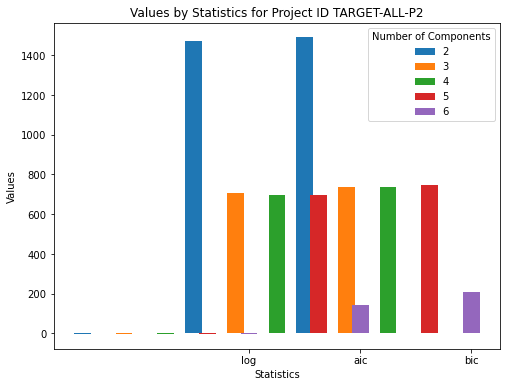

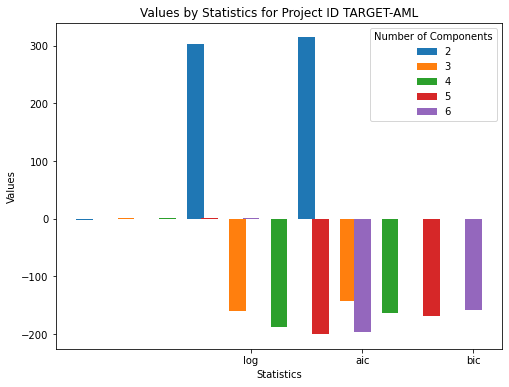

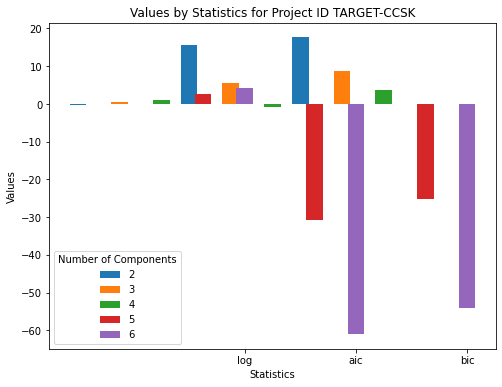

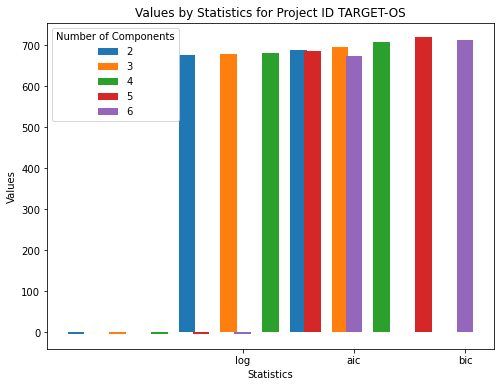

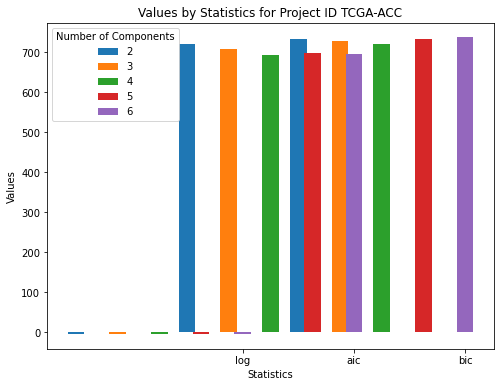

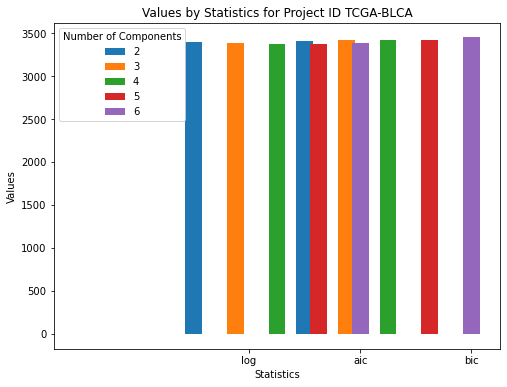

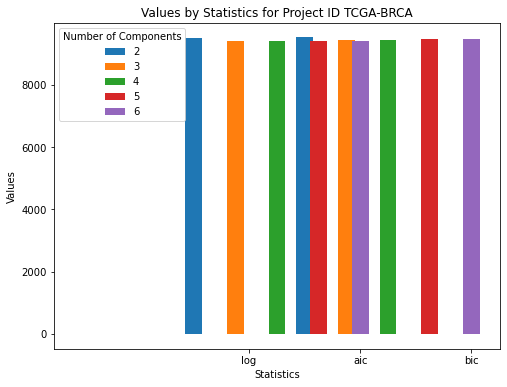

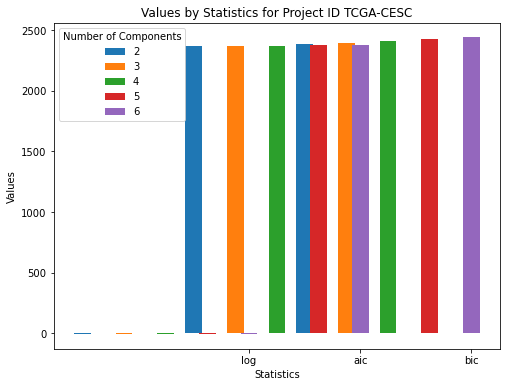

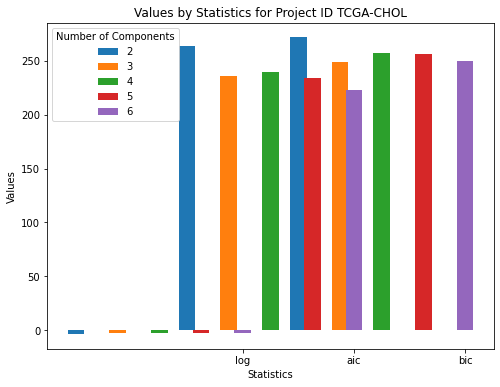

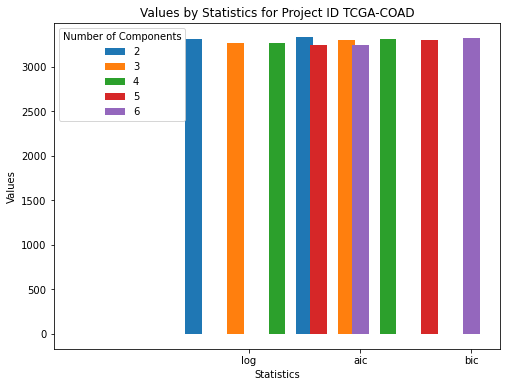

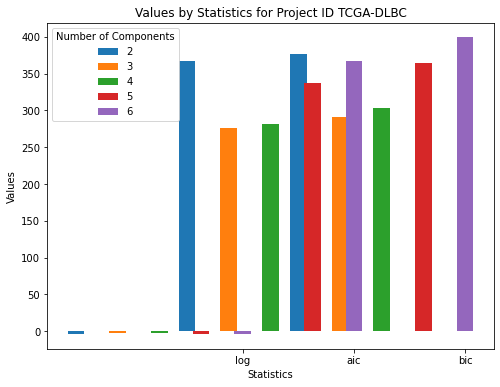

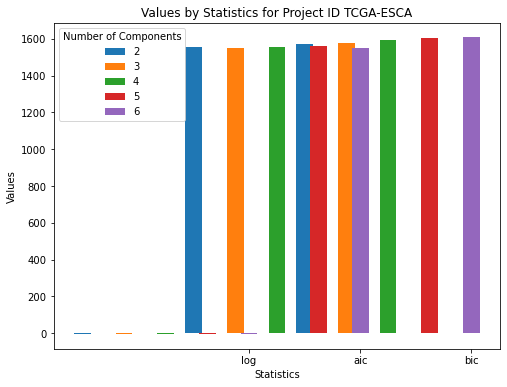

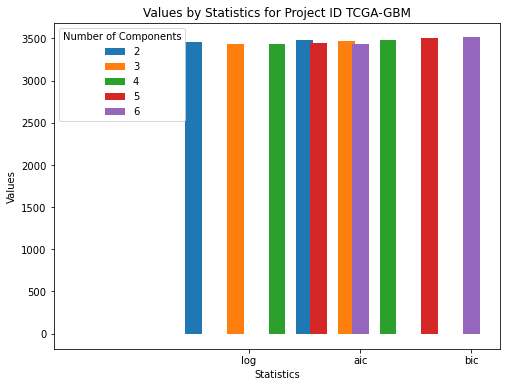

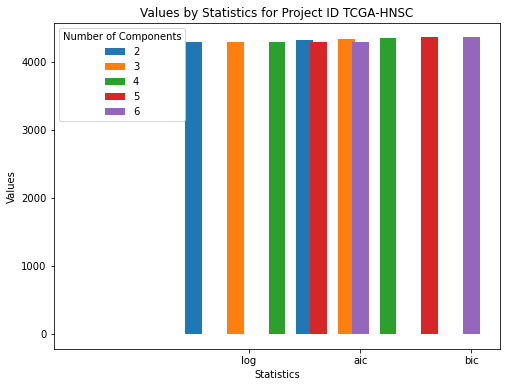

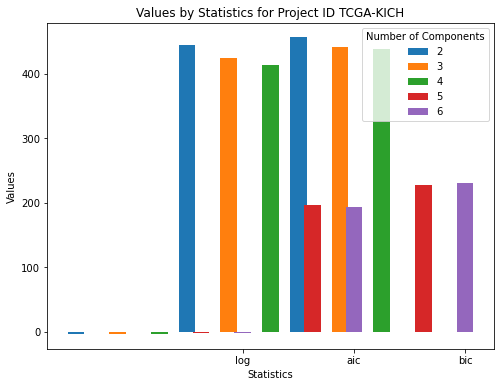

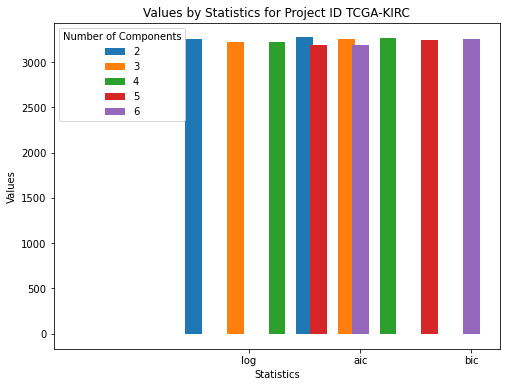

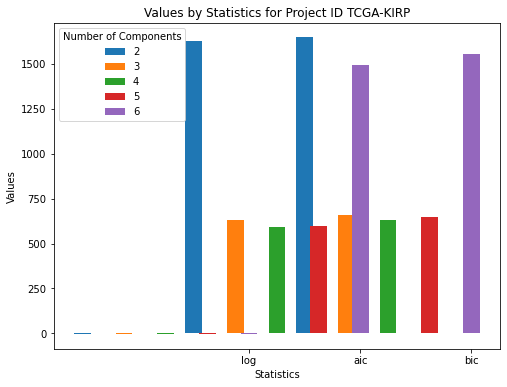

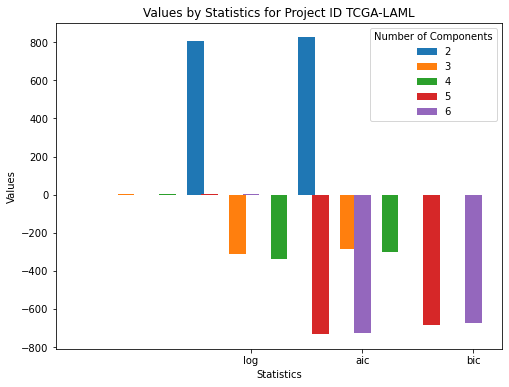

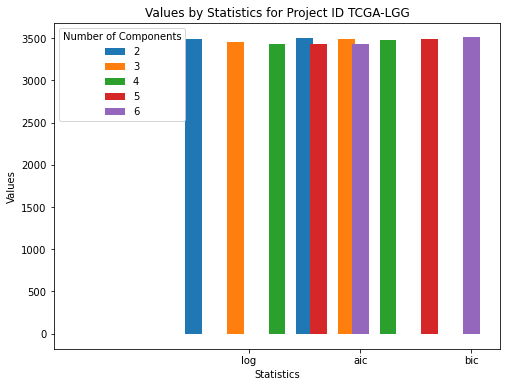

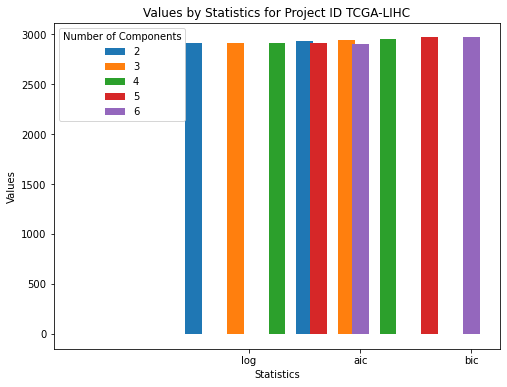

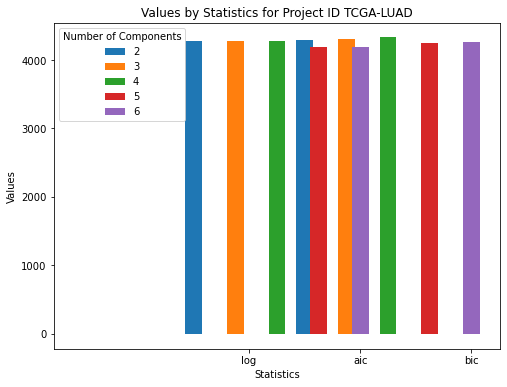

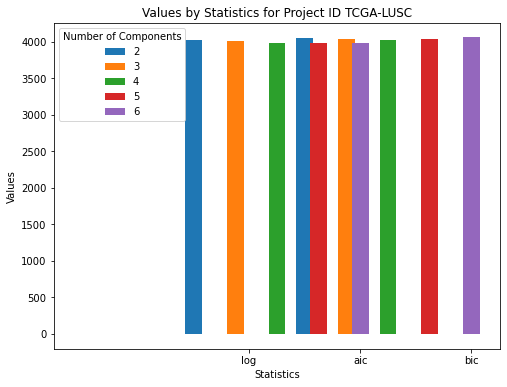

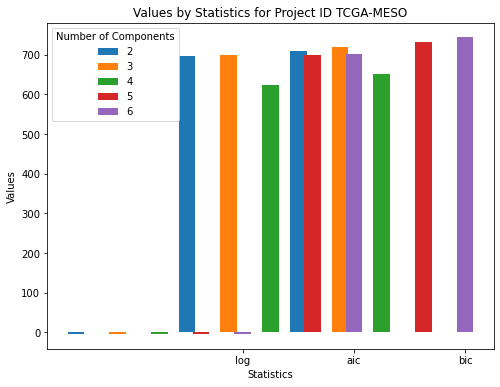

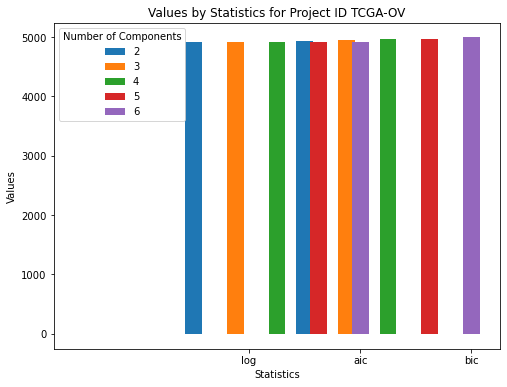

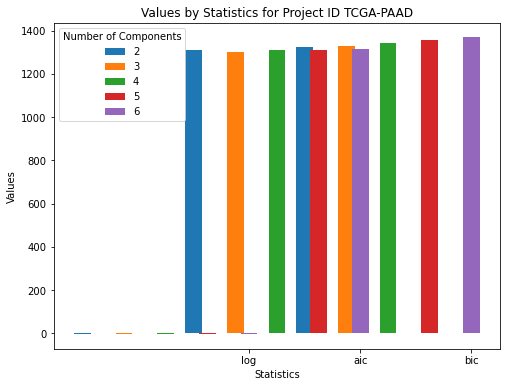

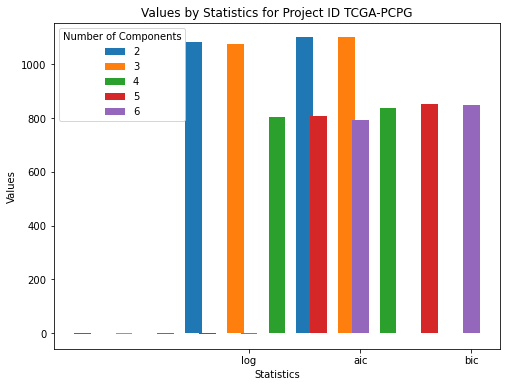

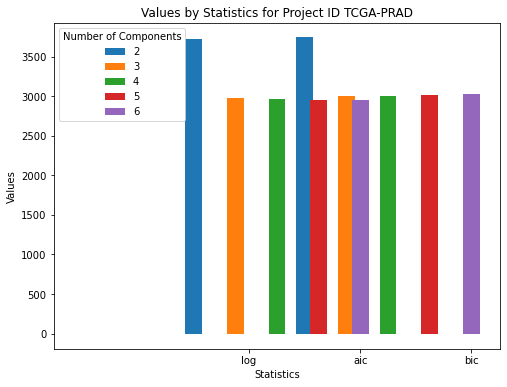

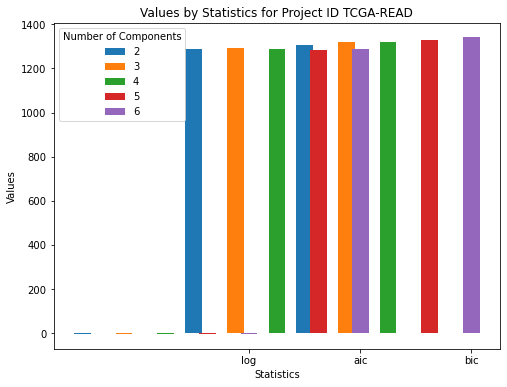

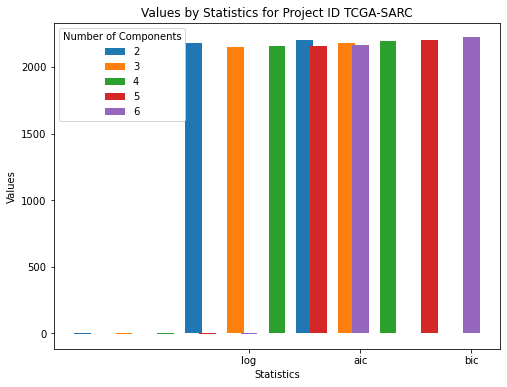

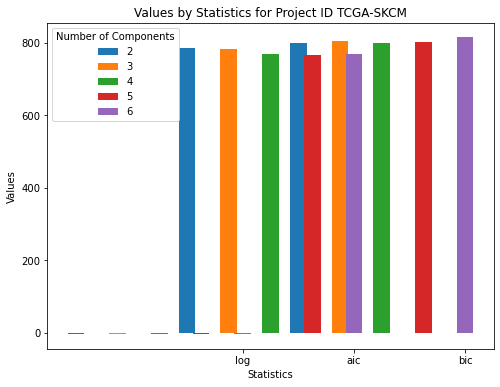

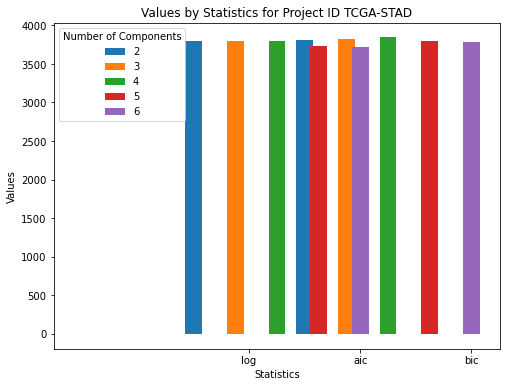

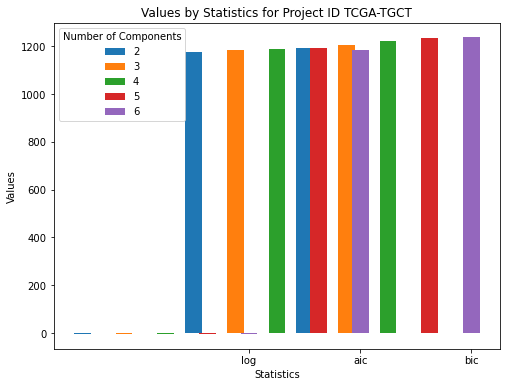

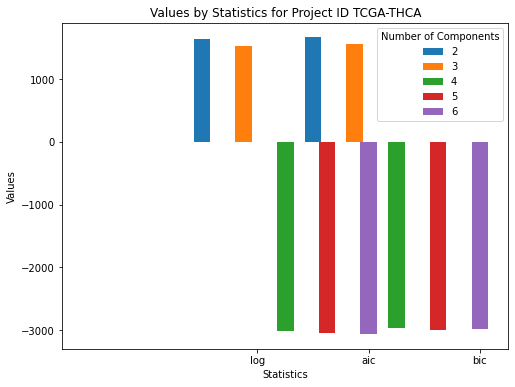

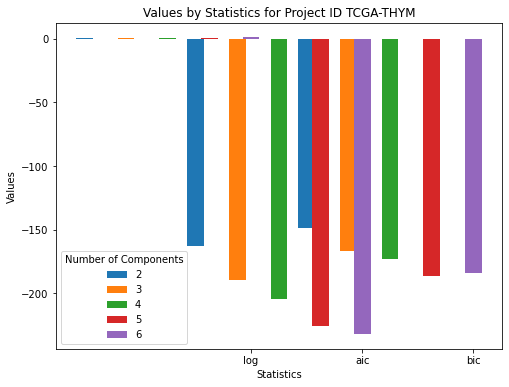

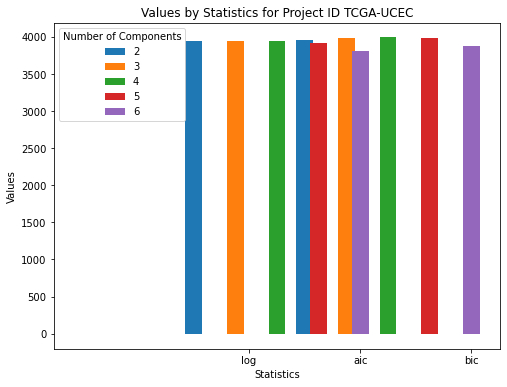

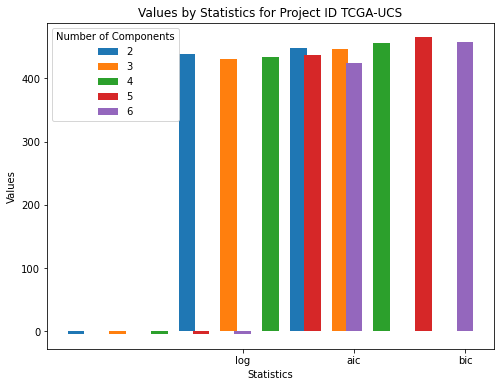

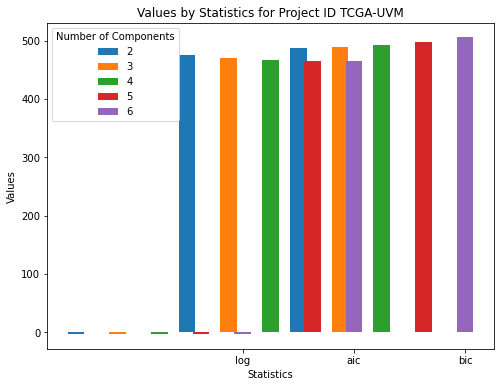

In [32]:
plotStatistics(results)

# With Plots, Lung Cancer

# LUSC

Label: 0
309
21.0
Label: 1
114
52.0
Label: 2
49
0.0
Label: 0
309
21.0
Label: 1
114
52.0
Label: 2
49
0.0
Label: 0
114
52.0
Label: 1
309
21.0
Label: 2
49
0.0
Label: 0
114
52.0
Label: 1
309
21.0
Label: 2
49
0.0
Label: 0
114
52.0
Label: 1
49
0.0
Label: 2
309
21.0
Label: 0
114
52.0
Label: 1
309
21.0
Label: 2
49
0.0
Label: 0
114
52.0
Label: 1
309
21.0
Label: 2
49
0.0
Label: 0
114
52.0
Label: 1
309
21.0
Label: 2
49
0.0
Label: 0
49
0.0
Label: 1
114
52.0
Label: 2
309
21.0
Label: 0
114
52.0
Label: 1
49
0.0
Label: 2
309
21.0
Label: 0
309
21.0
Label: 1
49
0.0
Label: 2
114
52.0
Label: 0
114
52.0
Label: 1
309
21.0
Label: 2
49
0.0
Label: 0
49
0.0
Label: 1
114
52.0
Label: 2
309
21.0
Label: 0
114
52.0
Label: 1
309
21.0
Label: 2
49
0.0
Label: 0
114
52.0
Label: 1
49
0.0
Label: 2
309
21.0
Label: 0
309
21.0
Label: 1
114
52.0
Label: 2
49
0.0
Label: 0
114
52.0
Label: 1
309
21.0
Label: 2
49
0.0
Label: 0
114
52.0
Label: 1
49
0.0
Label: 2
309
21.0
Label: 0
49
0.0
Label: 1
114
52.0
Label: 2
309
21.0
Label: 0
49


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Label: 0
114
52.0
Label: 1
309
21.0
Label: 2
49
0.0
Label: 0
309
21.0
Label: 1
49
0.0
Label: 2
114
52.0


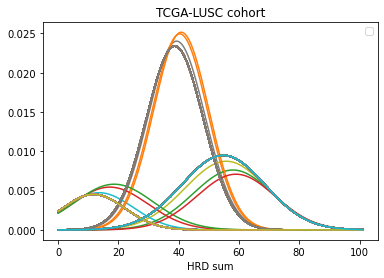

In [13]:
cancer_type = 'TCGA-LUSC'
HRD_scores_pan_cancer_type = HRD_scores_pan_cancer[HRD_scores_pan_cancer['Project ID'] == cancer_type]
HRD_type_primary = HRD_scores_pan_cancer_type[HRD_scores_pan_cancer_type['Type'] == 'Primary']
testing_gmm = HRD_type_primary[['Sample ID','HRD_sum']]
test_all_scores = HRD_type_primary[['Sample ID','HRD_sum','LST','TAI','LOH']]
testing_gmm.set_index('Sample ID', inplace=True)
test_all_scores.set_index('Sample ID', inplace=True)

n = 3
# create a GMM model with 3 components
plt.figure(facecolor=(1, 1, 1))
for i in range(0,100):
    data = testing_gmm.copy()
    #np.random.seed(42)
    gmm = GaussianMixture(n_components=n,max_iter = 1000, n_init = 10)

    # fit the model to the data
    gmm.fit(data)

    # predict the cluster labels for each data point
    labels = gmm.predict(data)

    # get the parameters of each component
    means = gmm.means_
    covariances = gmm.covariances_
    weights = gmm.weights_

    # create a range of values for the x-axis
    x = np.linspace(data.min(), data.max(), 1000)
    # create a plot for each component
    pdf_list = list()
    for i in range(len(weights)):
        # calculate the probability density function for the component
        pdf = weights[i] * np.exp(-(x - means[i])**2 / (2 * covariances[i])) / np.sqrt(2 * np.pi * covariances[i])
        pdf_list.append(pdf)
        # plot the PDF as a curve
        plt.plot(x, pdf)
    data['label'] = labels
    for lab in np.unique(data['label']):
        n_cases = data[data['label'] == lab]
        print('Label: '+str(lab))
        print(n_cases.shape[0])
        print(min(n_cases['HRD_sum']))

plt.xlabel('HRD sum')
plt.title(cancer_type +' cohort')
# display the plot
if n == 2:
    plt.savefig("../data/GMM_n2_LUSC.png", bbox_inches='tight')
else:
    plt.savefig("../data/GMM_n3_LUSC.png", bbox_inches='tight')

# LUAD

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


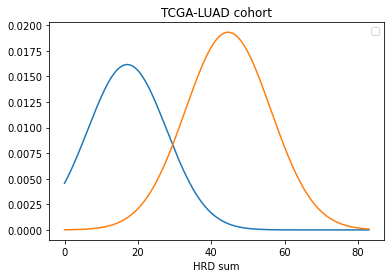

In [16]:
cancer_type = 'TCGA-LUAD'
HRD_scores_pan_cancer_type = HRD_scores_pan_cancer[HRD_scores_pan_cancer['Project ID'] == cancer_type]
HRD_type_primary = HRD_scores_pan_cancer_type[HRD_scores_pan_cancer_type['Type'] == 'Primary']
testing_gmm = HRD_type_primary[['case_id','HRD_sum']]
test_all_scores = HRD_type_primary[['case_id','HRD_sum','LST','TAI','LOH']]
testing_gmm.set_index('case_id', inplace=True)
test_all_scores.set_index('case_id', inplace=True)

n = 2

# create a GMM model with 3 components
plt.figure(facecolor=(1, 1, 1))
for i in range(0,1):
    data = testing_gmm.copy()
    np.random.seed(42)
    gmm = GaussianMixture(n_components=n,max_iter = 1000, n_init = 10)

    # fit the model to the data
    gmm.fit(data)

    # predict the cluster labels for each data point
    labels = gmm.predict(data)

    # get the parameters of each component
    means = gmm.means_
    covariances = gmm.covariances_
    weights = gmm.weights_

    # create a range of values for the x-axis
    x = np.linspace(data.min(), data.max(), 1000)
    # create a plot for each component
    pdf_list = list()
    for i in range(len(weights)):
        # calculate the probability density function for the component
        pdf = weights[i] * np.exp(-(x - means[i])**2 / (2 * covariances[i])) / np.sqrt(2 * np.pi * covariances[i])
        pdf_list.append(pdf)
        # plot the PDF as a curve
        plt.plot(x, pdf)
    data['label'] = labels
    #for lab in np.unique(data['label']):
       # n_cases = data[data['label'] == lab]
        #print('Label: '+str(lab))
       # print(n_cases.shape[0])

plt.xlabel('HRD sum')
plt.title(cancer_type +' cohort')
# display the plot
if n == 2:
    plt.savefig("../data/GMM_n2_LUAD.png", bbox_inches='tight')
else:
    plt.savefig("../data/GMM_n3_LUAD.png", bbox_inches='tight')

# HNSC

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


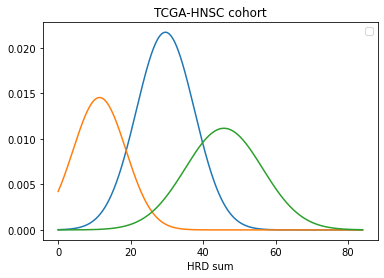

In [18]:
cancer_type = 'TCGA-HNSC'
HRD_scores_pan_cancer_type = HRD_scores_pan_cancer[HRD_scores_pan_cancer['Project ID'] == cancer_type]
HRD_type_primary = HRD_scores_pan_cancer_type[HRD_scores_pan_cancer_type['Type'] == 'Primary']
testing_gmm = HRD_type_primary[['case_id','HRD_sum']]
test_all_scores = HRD_type_primary[['case_id','HRD_sum','LST','TAI','LOH']]
testing_gmm.set_index('case_id', inplace=True)
test_all_scores.set_index('case_id', inplace=True)

n = 3
# create a GMM model with 3 components
plt.figure(facecolor=(1, 1, 1))
for i in range(0,1):
    data = testing_gmm.copy()
    np.random.seed(42)
    gmm = GaussianMixture(n_components=n,max_iter = 1000, n_init = 10)

    # fit the model to the data
    gmm.fit(data)

    # predict the cluster labels for each data point
    labels = gmm.predict(data)

    # get the parameters of each component
    means = gmm.means_
    covariances = gmm.covariances_
    weights = gmm.weights_

    # create a range of values for the x-axis
    x = np.linspace(data.min(), data.max(), 1000)
    # create a plot for each component
    pdf_list = list()
    for i in range(len(weights)):
        # calculate the probability density function for the component
        pdf = weights[i] * np.exp(-(x - means[i])**2 / (2 * covariances[i])) / np.sqrt(2 * np.pi * covariances[i])
        pdf_list.append(pdf)
        # plot the PDF as a curve
        plt.plot(x, pdf)
    data['label'] = labels
    #for lab in np.unique(data['label']):
       # n_cases = data[data['label'] == lab]
        #print('Label: '+str(lab))
       # print(n_cases.shape[0])

plt.xlabel('HRD sum')
plt.title(cancer_type +' cohort')

# display the plot
if n == 2:
    plt.savefig("../data/GMM_n2_HNSC.png", bbox_inches='tight')
else:
    plt.savefig("../data/GMM_n3_HNSC.png", bbox_inches='tight')